# Adversarial Attack 

- develop a model for mnist dataset using fastai
- attack the model using foolbox (black box attack)
- check the density & coverage metrics

In [1]:
# dependencies
import os 
os.environ["GIT_PYTHON_REFRESH"] = "quiet" 
#!module load git
import foolbox as fb
import torch
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import numpy as np
from n2gem.metrics import gem_build_coverage, gem_build_density
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import torchvision
from fastai.vision.all import *
from fastai.vision import *

In [3]:
import medmnist
from medmnist import INFO, Evaluator

Fix the seed generator

In [4]:
torch.manual_seed(42) 
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device); print(torch.cuda.memory_allocated())
torch.cuda.device_count()

cuda
0


1

In [6]:
from skmultilearn.model_selection import iterative_train_test_split

### Import the MNIST dataset 

In [101]:
def load_mnist():
    """Function to load the mnist
        The following transform is aaplied: Normalize:(0.1307,)(0.3081,)
    
    """
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
        #torchvision.transforms.Normalize((0.1307,), (0.3081))
    ])
    train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transforms)
    test_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transforms)
    
    return train_set, test_set

train_set, test_set = load_mnist()

In [102]:
dataset = torch.utils.data.ConcatDataset([train_set, test_set])
X=[]; Y=[];
for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x.numpy())  #.detach().cpu().numpy())
    Y.append(y)

In [164]:
xx = np.array(X)
zz = (xx - np.mean(xx)) / np.std(xx)
zz.max(), zz.min()

(2.8175676, -0.42446432)

### Import the MEDMNIST dataset 

In [15]:
#from torch.utils.data import Dataset
data_transform = torchvision.transforms.Compose([
    #torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.Normalize((0.6146,),(0.1537,)) # pathmnist grayscale-normalize values
    #torchvision.transforms.Normalize((0.74,0.53,0.71), (0.12,0.18,0.13)) # pathmnist RGB normalize values
    #torchvision.transforms.Normalize((0.5,0.5, 0.5), (0.5,0.5,0.5)) 
    #torchvision.transforms.Normalize((0.4938), (0.2381))  # chestmnist
    #torchvision.transforms.Normalize((0.4657), (0.2936))  # organmnist
    
])
tar_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])
class LoadMed(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, transform):
        
        self.images = imgs
        self.labels = labels
        self.transform = transform
        
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        
        img, target = self.images[idx], self.labels[idx].astype(int)
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)
        

        return img, target
        
        
        

npz_file = np.load('/home/venkat31/.medmnist/pathmnist.npz')

train_imgs = npz_file['train_images']
test_imgs = npz_file['test_images']
val_imgs = npz_file['val_images']

train_labels = npz_file['train_labels']
test_labels = npz_file['test_labels']
val_labels = npz_file['val_labels']

In [32]:
data_flag = 'chestmnist'
# data_flag = 'breastmnist'
#download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
print(n_classes)

14


In [16]:
arr_X_dataset = np.concatenate([train_imgs, test_imgs, val_imgs])
arr_Y_dataset = np.concatenate([train_labels, test_labels, val_labels])

In [17]:
arr_X_dataset.shape

(107180, 28, 28, 3)

In [40]:
print(arr_Y_dataset.shape)
np.unique(arr_Y_dataset, return_counts=True)

(58850, 1)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 array([ 3313,  2425,  2377,  2651,  6595,  6419, 10482,  6699,  6751,
         5182,  5956]))

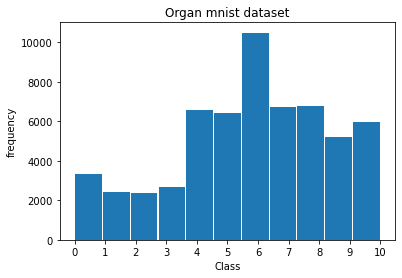

In [30]:
plt.hist(arr_Y_dataset.ravel(),  rwidth=0.96, bins=11)
plt.xticks(np.arange(0,11,1), np.arange(0,11,1))
plt.xlabel('Class')
plt.ylabel('frequency')
plt.title('Organ mnist dataset')
plt.savefig('Organmnist_lables_hist.png')

In [18]:
dataset = LoadMed(arr_X_dataset, arr_Y_dataset, data_transform)

In [11]:
model_imgs=[]; model_labels=[]
for i in range(len(dataset)):
    x,y = dataset[i]
    model_imgs.append(x)
    model_labels.append(torch.from_numpy(y))

In [12]:
model_imgs[0].shape

torch.Size([1, 28, 28])

In [14]:
new_modelimgs = torch.stack(model_imgs)
new_modelimgs.std()

tensor(0.1537)

### Chestmnist startify split

In [10]:
X_train, y_train, X_test, y_test = iterative_train_test_split(arr_X_dataset, arr_Y_dataset, test_size = 0.03)

In [11]:
x_train, yy_train, x_test, yy_test = iterative_train_test_split(X_train, y_train, test_size = 0.3)

In [22]:
x_train.shape, x_test.shape

((76129, 28, 28), (32627, 28, 28))

In [12]:
model_dataset = LoadMed(X_train, y_train, data_transform)
model_imgs=[]; model_labels=[]
for i in range(len(model_dataset)):
    x,y = model_dataset[i]
    model_imgs.append(x)
    model_labels.append(torch.from_numpy(y))
    
print(len(model_imgs), len(model_labels))


108756 108756


In [68]:
type(model_labels[0])

torch.Tensor

In [14]:
new_modelimgs = torch.stack(model_imgs)
new_modellab = torch.stack(model_labels)

new_modelimgs.mean()

tensor(-0.0003)

In [15]:
torch.save(new_modelimgs, 'chestmnist_model_images.pt')
torch.save(new_modellab, 'chestmnist_model_labels.pt')

In [23]:
train_set = LoadMed(x_train, yy_train, data_transform)
test_set = LoadMed(x_test, yy_test, data_transform)

In [7]:
train_set = LoadMed(train_imgs, train_labels, data_transform)
test_set = LoadMed(test_imgs, test_labels, data_transform)

In [16]:
val_set = LoadMed(X_test, y_test, data_transform)

In [17]:
val_set[0][0].std(), len(val_set)

(tensor(0.9869), 3364)

In [18]:
val_imgs = []; val_labels=[]
for i in range(len(val_set)):
    x, y = val_set[i]
    val_imgs.append(x.numpy())
    val_labels.append(torch.from_numpy(y))

In [19]:
len(val_labels)

3364

In [20]:
torch.save(val_imgs, 'chestmnist_validation_images.pt')
torch.save(val_labels, 'chestmnist_validation_labels.pt')

In [20]:
x, y = train_set[0]
x.shape, y.shape

(torch.Size([1, 28, 28]), (14,))

In [43]:
imgs = torch.stack([img for img,_ in train_set])
imgs.shape

ValueError: pic should be 2/3 dimensional. Got 1 dimensions.

In [19]:
g = imgs.reshape(imgs.shape[0], -1)
g.mean(), g.std()

(tensor(-9.0690e-05), tensor(1.0001))

-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------

### Combine the datasets and stratify split 
- Combine train and test
- form the model_dataset[training+ test] and validation set
- obtain training & test set to train on the model from model_dataset

In [19]:
from torch.utils.data import ConcatDataset
from sklearn.model_selection import train_test_split

def create_dataset(dataset, vali_split, test_split, train_set=None, test_set=None):
    """Function to split the dataset and form the training, test and validation datasets
        
        Parameters
        ----------------------
        train_set: torch.utils.mnist.dataset
        test_set: torch.utils.mnist.dataset
        vali_split: the size for the validation set 
        test_split: the size of the test set
        
        Return
        ----------------------
        X_trainset: list, size: train_size, 1, 28, 28
        X_testset: list, size: test_size, 1, 28, 28
        X_validation: list, size: vali_size, 1, 28, 28
        y_trainset: list, size: train_size
        y_testset: list, size: test_size
        y_valiset: list, size: vali_size
        
    """
    # combine the datasets
    if not dataset:
        dataset = ConcatDataset([train_set, test_set])
    
    X=[]; Y=[];
    for i in range(len(dataset)):
        x, y = dataset[i]
        X.append(x.numpy())  #.detach().cpu().numpy())
        Y.append(y)
    
    # split the dataset into train and validation set
    X_model, X_validation, y_model, y_validation = train_test_split(X, Y, test_size=vali_split, random_state=42, stratify=np.array(Y))

    print("X_validation_set size: ", np.array(X_validation).shape)
    print("Y_validation_set size: ", len(y_validation))
    
    # split the X_model, y_model into training set & test set
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_model, y_model, test_size=test_split, random_state=42, stratify=np.array(y_model))
    print("X_train_set size: ", np.array(X_trainset).shape)
    print("Y_train_set size: ", len(y_trainset))
    print("X_test_set size: ", np.array(X_testset).shape)
    print("Y_test_set size: ", len(y_testset))
    
    #X = np.array(X); Y = np.array(Y)
    
    return X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation

# mnist
#X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation = create_dataset(False, 0.03, 0.2, train_set=train_set, test_set=test_set)

# pathmnist
X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation = create_dataset(dataset, 0.05, 0.2)

# organmnist
#X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation = create_dataset(dataset, 0.08, 0.2)

X_validation_set size:  (5359, 1, 28, 28)
Y_validation_set size:  5359
X_train_set size:  (81456, 1, 28, 28)
Y_train_set size:  81456
X_test_set size:  (20365, 1, 28, 28)
Y_test_set size:  20365


In [62]:
y_trainset[0]

array([5])

In [47]:
model_set = np.vstack((y_trainset, y_testset))

In [48]:
model_set2 = np.array(y_validation)

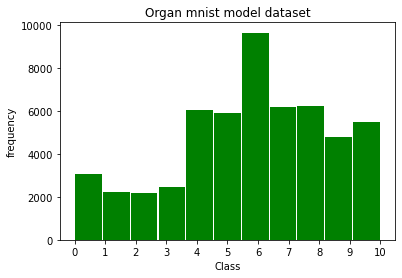

In [55]:
plt.hist(model_set, rwidth=0.96, bins=11, color='g')
plt.xticks(np.arange(0,11,1), np.arange(0,11,1))
plt.xlabel('Class')
plt.ylabel('frequency')
plt.title('Organ mnist model dataset')
plt.savefig('Organmnist_modeldatasetlables_hist.png')

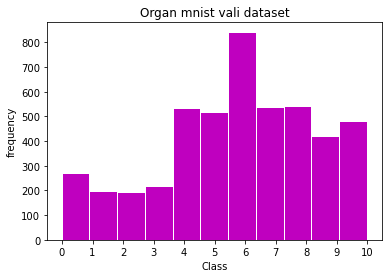

In [57]:
plt.hist(model_set2, rwidth=0.96, bins=11, color='m')
plt.xticks(np.arange(0,11,1), np.arange(0,11,1))
plt.xlabel('Class')
plt.ylabel('frequency')
plt.title('Organ mnist vali dataset')
plt.savefig('Organmnist_valdatasetlables_hist.png')

### Convert the datasets to Torch.TensorDataset

In [20]:
def convert_tensor(X_trainset, X_testset, y_trainset, y_testset, X_validation, y_validation):
    """
    Function to convert the split datasets into torch Tensor dataset
    
    Parameters
    ----------------------
    X_trainset: list, size: train_size, 1, 28, 28
    X_testset: list, size: test_size, 1, 28, 28
    X_validation: list, size: vali_size, 1, 28, 28
    y_trainset: list, size: train_size
    y_testset: list, size: test_size
    y_valiset: list, size: vali_size
    
    Return
    -------------------
    train_set: TensorDataset, consists of training images and labels
    test_set: TensorDataset, consists of test images and labels
    validation_set: TensorDataset, consists of validation images and labels
    
    # for the adversarial attack
    model_dataset_images: Tensor, size: (training + test) size, only the images
    model_dataset_images: Tensor, size: (training + test) size, only the labels
    """
    X_trainset = torch.Tensor(X_trainset); 
    y_trainset = torch.Tensor(y_trainset).type(torch.LongTensor).view(-1) #dtype = torch.long);
    X_testset = torch.Tensor(X_testset); 
    y_testset = torch.Tensor(y_testset).type(torch.LongTensor).view(-1);
    X_validation = torch.Tensor(X_validation); 
    y_validation = torch.Tensor(y_validation).type(torch.LongTensor).view(-1)
    
    print(X_trainset.shape, y_trainset.shape)
    # y - label should be longTensor for fastai training
    
    # form model_dataset
    model_dataset_images = torch.vstack((X_trainset, X_testset))
    model_dataset_labels = torch.cat((y_trainset, y_testset))
    #model_dataset_labels = torch.vstack((y_trainset, y_testset))
    
    # form the Tensor dataset
    train_set = torch.utils.data.TensorDataset(X_trainset, y_trainset)
    test_set = torch.utils.data.TensorDataset(X_testset, y_testset)
    validation_set = torch.utils.data.TensorDataset(X_validation, y_validation)
    
    return train_set, test_set,  model_dataset_images, model_dataset_labels , validation_set,

train_set, test_set,  model_images, model_labels, validation_set = convert_tensor(X_trainset, X_testset, y_trainset, y_testset, X_validation,  y_validation)

torch.Size([81456, 1, 28, 28]) torch.Size([81456])


In [7]:
test_imgs_mean = (test_imgs/255).mean()
test_imgs_std = (test_imgs/255).std()
test_imgs = ((test_imgs/255) - test_imgs_mean) / test_imgs_std

In [8]:
train_imgs_mean = (train_imgs/255).mean()
train_imgs_std = (train_imgs/255).std()
train_imgs = ((train_imgs/255) - train_imgs_mean) / train_imgs_std

In [9]:
train_labels.shape

(78468, 14)

In [10]:
train_imgs_new = train_imgs[:, np.newaxis,:,:]
train_imgs_new.shape
test_imgs_new = test_imgs[:, np.newaxis,:,:]
test_imgs_new.shape

(22433, 1, 28, 28)

In [11]:
x_train_imgs = torch.from_numpy(train_imgs_new).type(torch.float)
x_test_imgs = torch.from_numpy(test_imgs_new).type(torch.float)

y_train_labels = torch.from_numpy(train_labels).type(torch.float)
y_test_labels = torch.from_numpy(test_labels).type(torch.float)

In [12]:
y_train_labels.shape

torch.Size([78468, 14])

In [13]:
train_set = torch.utils.data.TensorDataset(x_train_imgs, y_train_labels)
test_set = torch.utils.data.TensorDataset(x_test_imgs, y_test_labels)

In [74]:
len(y_validation), type(X_validation)

(4708, list)

In [71]:
torch.save(model_images, 'organmnist_model_images.pt')
torch.save(model_labels, 'organmnist_model_labels.pt')

In [75]:
torch.save(X_validation, 'organmnist_validation_images.pt')
torch.save(y_validation, 'organmnist_validation_labels.pt')

### The Dataloader for the CNN models

In [28]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True)

### Define the CNN model

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=7)
        #self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        #self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*11*11, 128)
        #self.fc3 = nn.Linear(512, 32)
        self.fc4 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        #x = self.drop(self.conv2(x))
        #x = self.conv2(x)
        #x = F.relu(F.max_pool2d(x, 2))
        #print(x.shape)
        x = x.view(-1, 4*11*11)
        x = F.relu(self.fc1(x))
        #x = self.drop(x)
        #x = F.relu(self.fc3(x))
        #x = self.drop(x)
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [40]:
import torch.nn as nn
# for overfit model: dropout is removed and trained for 50 epochs
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        """self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
            
        self.fc = nn.Sequential(
            nn.Linear(64 * 2 * 2, 128), # b4- conv5 output 64*4*4
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 9))"""
        
        # pathmnist Grayscale modifications
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Sequential(
            nn.Linear(64 * 5 * 5, 1024), # b4- conv5 output 64*4*4
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 9))
        
        #self.conv6 = nn.Sequential(
        #    nn.Conv2d(64, 64, kernel_size=3),
        #    nn.BatchNorm2d(64),
        #    nn.ReLU()) # added extra for Grayscale pathmnist

        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.conv4(x)
        #x = self.conv5(x)
        #x = self.conv6(x) # added extra for Grayscale pathmnist
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

In [6]:
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(F.max_pool2d(x, 2))
        #x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 800)
        x = self.drop(F.relu(self.fc1(x)))
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
        #return x

In [25]:
class New(nn.Module):
    def __init__(self):
        super(New, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(32*13*13, 2048),
            nn.ReLU(),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128, 14)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1)
        
        x = self.layer2(x)
        return x

Get the parameteres from the model

In [47]:
model = NewNet()
#model = New()
#model = CNet()
param = [p for p in list(model.parameters()) if p.requires_grad]
uniq = {p.data_ptr(): p for p in list(model.parameters())}.values()
print(sum(p.numel() for p in uniq))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
#print(sum(p.numel() for p in model1.parameters() if p.requires_grad))

448654
448654


### Fastai classifier
- Fastai takes the available device by default

In [41]:
data = DataLoaders(train_loader, test_loader)
path_learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)
#learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)
#learn1 = Learner(data, CNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)
#chest_learn = Learner(data, NewNet(), loss_func=torch.nn.BCEWithLogitsLoss(), opt_func=Adam, metrics=accuracy_multi)
#chest_learn = Learner(data, NewNet(), loss_func=BCEWithLogitsLossFlat(), opt_func=Adam, metrics=[accuracy_multi])
#f1score = F1Score(average='macro')
#organ_learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=[accuracy, f1score])

In [112]:
organ_learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.226268,0.259486,0.908856,0.902710,00:04
1,0.085762,0.077813,0.974328,0.972682,00:04


SuggestedLRs(valley=tensor(0.0002))

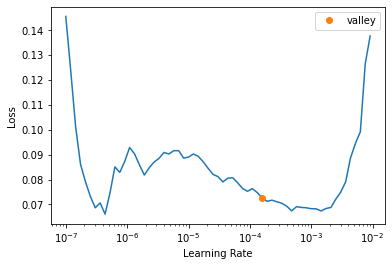

In [109]:
organ_learn.unfreeze()
organ_learn.lr_find()

In [113]:
organ_learn.fit_one_cycle(8, lr_max=1e-4)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.073704,0.070860,0.977099,0.974867,00:04
1,0.055526,0.060227,0.979500,0.977010,00:04
2,0.039655,0.051474,0.983286,0.982421,00:04
3,0.037482,0.040635,0.986333,0.985162,00:04
4,0.028681,0.039144,0.986425,0.985212,00:04
5,0.020967,0.035160,0.988180,0.986964,00:04
6,0.014825,0.033181,0.989288,0.988341,00:04
7,0.015440,0.033093,0.988919,0.987576,00:04


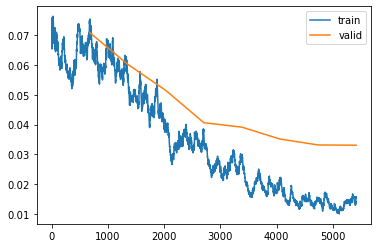

In [114]:
organ_learn.recorder.plot_loss()

In [42]:
path_learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.814224,0.754302,0.727179,00:06
1,0.558663,0.495626,0.817137,00:06
2,0.450383,0.417708,0.847140,00:06


SuggestedLRs(valley=tensor(4.3652e-05))

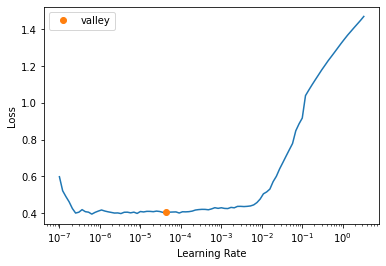

In [43]:
path_learn.unfreeze()
path_learn.lr_find()

In [44]:
path_learn.fit_one_cycle(10, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.439177,0.414963,0.848760,00:06
1,0.424374,0.415229,0.848760,00:06
2,0.449803,0.411164,0.848515,00:06
3,0.415755,0.410941,0.851019,00:06
4,0.410901,0.407971,0.850773,00:06
5,0.439275,0.408837,0.851019,00:06
6,0.419964,0.405629,0.852296,00:06
7,0.399746,0.405654,0.852050,00:06
8,0.422901,0.404507,0.852296,00:06
9,0.412956,0.403730,0.853032,00:06


In [115]:
organ_learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.193925,0.200708,0.935636,0.927127,00:04


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.086230,0.089530,0.969526,0.967524,00:04
1,0.072496,0.094234,0.968603,0.966817,00:04
2,0.040987,0.039734,0.986887,0.985020,00:04
3,0.011477,0.022079,0.991874,0.990951,00:04
4,0.005267,0.017702,0.993351,0.992281,00:04


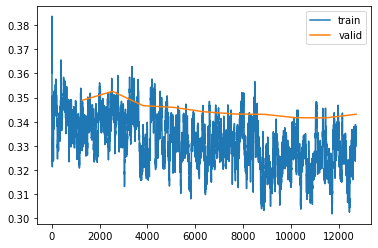

In [34]:
path_learn.recorder.plot_loss()

## ResNet models 

In [47]:
data = DataLoaders(train_loader, test_loader)
resmodel = models.resnet18(num_classes=14)
resmodel.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7)
#model.fc = torch.nn.Linear(512, 10)
#print(model)

In [48]:
print(sum(p.numel() for p in resmodel.parameters() if p.requires_grad))

11177486


In [49]:
# resnet model for training 
learn = Learner(data, resmodel, loss_func=BCEWithLogitsLossFlat(), opt_func=Adam, metrics=accuracy_multi)

In [50]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.168366,0.183845,0.947619,00:22
1,0.160792,0.166119,0.947682,00:21
2,0.158954,0.162964,0.947902,00:21


In [92]:
learn.save('./fastai_resnet34')
model_new = learn.load('fastai_resnet34')
torch.save(model_new.model.state_dict(), 'fastai_resnet34_weights.pt')

In [111]:
#learn.fit(30)

- Initial fit for the model

In [114]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,0.315950,0.306789,0.912297,00:03
1,0.165154,0.159734,0.953093,00:03
2,0.097478,0.092330,0.972018,00:03
3,0.068718,0.060984,0.981885,00:03
4,0.052096,0.051989,0.983505,00:04
5,0.052169,0.047056,0.985272,00:03
6,0.035102,0.036929,0.988513,00:03
7,0.028907,0.033353,0.990133,00:03
8,0.025092,0.038318,0.988365,00:03
9,0.020819,0.041170,0.988144,00:03


In [119]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,-2010.893433,-2393.189697,0.980854,00:14


epoch,train_loss,valid_loss,accuracy,time
0,-4762.945312,-5056.454102,0.987408,00:14
1,-9382.788086,-9654.258789,0.989396,00:14
2,-10707.206055,-10771.859375,0.993962,00:14


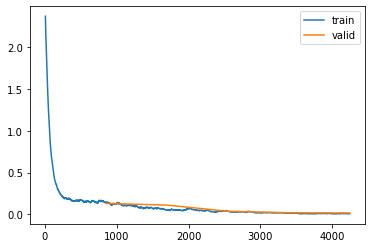

In [91]:
#lss = learn.recorder.losses
#plt.plot(lss)
learn.recorder.plot_loss()
plt.savefig('resnet34_mnist.png')

In [97]:
learn1.fit_one_cycle(3, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.089051,2.061274,0.600589,00:02
1,1.633292,1.615470,0.768851,00:02
2,1.520177,1.517953,0.777982,00:02


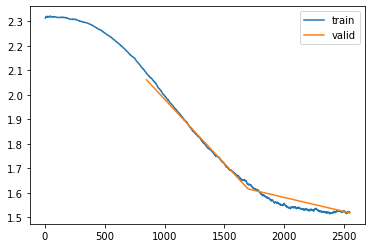

In [99]:
learn1.recorder.plot_loss()
plt.savefig('underfit_loss_3epochs.png')

- Unfreeze and check the optimal learning rate

SuggestedLRs(valley=tensor(0.0044))

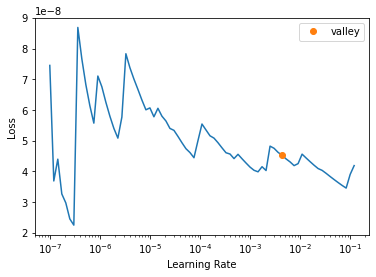

In [182]:
learn.unfreeze()
learn.lr_find()

- Fit the model again

In [139]:
learn.fit_one_cycle(30, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.012687,0.029881,0.990427,00:03
1,0.015406,0.029705,0.990722,00:03
2,0.020524,0.029592,0.990648,00:03
3,0.013447,0.029669,0.990501,00:03
4,0.012682,0.029653,0.990353,00:02
5,0.013864,0.029601,0.990353,00:03
6,0.011523,0.029591,0.990427,00:02
7,0.017564,0.029678,0.990648,00:03
8,0.014337,0.029848,0.990059,00:03
9,0.011938,0.029618,0.990427,00:03


In [56]:
learn.validate()

(#2) [0.0669793039560318,0.9913107752799988]

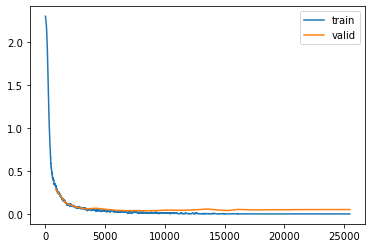

In [189]:
learn.recorder.plot_loss()
#plt.savefig('loss.png')

- Fine tune the model 

In [17]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.120263,0.065498,0.979750,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.064480,0.040627,0.987629,00:03
1,0.069494,0.044321,0.986230,00:03
2,0.051842,0.032422,0.989691,00:03
3,0.047426,0.030197,0.991090,00:03
4,0.035231,0.029030,0.991164,00:03


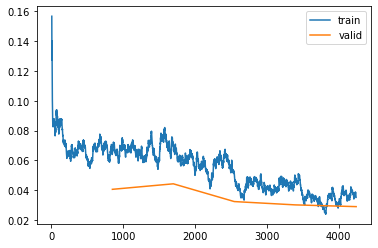

In [18]:
learn.recorder.plot_loss()

### - Save the fastai classifier
- By default it is saved in the /models folder with .pth extension

In [173]:
learn.save('./fastai_resnet50_splitDataset')

Path('models/fastai_resnet50_splitDataset.pth')

In [45]:
path_learn.save('./fastai_pathmnist_1C_85_NewNet')

Path('models/fastai_pathmnist_1C_85_NewNet.pth')

In [117]:
organ_learn.save('./fastai_organmnist_99_NewNet')

Path('models/fastai_organmnist_99_NewNet.pth')

- Load the model(fastai) and save it as torch model for foolbox compatibility

In [24]:
model_new = learn.load('fastai_cnn_NewNet_99_splitDataset')
torch.save(model_new.model.state_dict(), 'fastai_cnn_NewNet_99_splitDataset_weights.pth')

In [46]:
model_new1 = path_learn.load('fastai_pathmnist_1C_85_NewNet')
torch.save(model_new1.model.state_dict(), 'fastai_pathmnist_1C_85_NewNet_weights.pt')

In [118]:
model_new1 = organ_learn.load('fastai_organmnist_99_NewNet')
torch.save(model_new1.model.state_dict(), 'fastai_organmnist_99_NewNet_weights.pt')

---------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------

### Load model for the attack

In [47]:
# load the NewNet model
MyModel = NewNet()

# CNet
#MyModel = CNet()

# Resnet models
#MyModel = models.resnet50(num_classes=10)
#MyModel.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7)

# mnist, pathmnist, organmnist
#MyModel.load_state_dict(torch.load('chkpt_files/fastai_organmnist_99_NewNet_weights.pt', map_location=device))
#MyModel.load_state_dict(torch.load('chkpt_files/fastai_cnn_NewNet_99_splitDataset_weights.pth', map_location=device))
MyModel.load_state_dict(torch.load('./fastai_pathmnist_1C_85_NewNet_weights.pt', map_location=device))
MyModel.eval()
#print(torch.cuda.memory_allocated())
#print(MyModel)


# load the CNet model
#MyModel_1 = CNet()
#MyModel_1.load_state_dict(torch.load('fastai_cnn_weights.pth'))
#MyModel_1.eval()

NewNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1600, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, o

### Create a Pytorch model for foolbox attack

In [48]:
# mnist
#preprocess = dict(mean=0.1307, std=0.3081)

# pathmnist RGB normalize values
#preprocess = dict(mean=[0.74,0.53,0.71], std=[0.12,0.18,0.13], axis=-3)

# pathmnist Grayscale normalize values
preprocess = dict(mean=0.6146, std=0.1537)

# chestmnist
#preprocess = dict(mean=0.4938, std=0.2381)

# organmnist
#preprocess = dict(mean=0.4657, std=0.2936)
bound = (0, 1)
original_model = fb.PyTorchModel(MyModel, bounds=bound, preprocessing=preprocess)

- Three different attacks with 100 values of epsilons

In [49]:
#attack0 = fb.attacks.LinfPGD()
#attack1 = fb.attacks.BoundaryAttack()
attack2 = fb.attacks.FGSM()
#attack = [attack0, attack1, attack2]
epsilon = np.linspace(0.0, 1, num=20)

- Attack the ```trained network``` with model_dataset

In [50]:
def model_attack(attk, model, images, labels, epsilon):
    """
    Function to perform the adv attack on the pytorch model
    
    Parameters
    --------------------
    attk: type of foolbox attack
    model: foolbox Pytorch model
    image: the images used for the attack, either as ep.tensor or torch.tensor
            size:(no_of_samples x dims)
    labels: corresponding labels for the images, either as ep.tensor or torch.tensor
            size:(no_of_samples 
    epsilon: the pertubation
    
    Return
    -------------
    clip_adv: list, the actual adversarial examples generated for the given model
                size: similar to the input images
    adv_ : boolean list, indicating whether a given image is adversarial example or not,
            True - adversarial sample
            False - not an adversarial sample
    """
    raw_adv, clip_adv, adv_ = attk(model, images, labels, epsilons=epsilon)
    
    return clip_adv, adv_


## Attack the model using 20 epsilon & ```FGSM attack```

- Attack the model using validation_dataset (2100 images)
- The model_dataset has 20000 images, selected using stratify split

#### Load the the images

 mnist

In [8]:
md_images = torch.load('images/model_dataset_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/model_dataset_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/validation_labels.pt', map_location='cpu')

pathmnist RGB images

In [11]:
md_images = torch.load('images/pathmnist_model_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/pathmnist_model_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/pathmnist_validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/pathmnist_validation_labels.pt', map_location='cpu')

In [ ]:
print(np.unique(md_labels.cpu().numpy(), return_counts=True))
print(np.unique(np.array(vali_labels), return_counts=True))

pathmnist grayscale images

In [51]:
md_images = torch.load('./pathmnist_1C_model_images.pt', map_location='cpu').cpu()
md_labels = torch.load('./pathmnist_1C_model_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('./pathmnist_1C_validation_images.pt', map_location='cpu')
vali_labels = torch.load('./pathmnist_1C_validation_labels.pt', map_location='cpu')

chestmnist

In [9]:
md_images = torch.load('images/chestmnist_model_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/chestmnist_model_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/chestmnist_validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/chestmnist_validation_labels.pt', map_location='cpu')

In [85]:
print(np.unique(md_labels.cpu().numpy(), return_counts=True))
#print(np.unique(np.array(vali_labels), return_counts=True))

(array([0, 1]), array([1444026,   78558]))


organmnist

In [9]:
md_images = torch.load('images/organmnist_model_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/organmnist_model_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/organmnist_validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/organmnist_validation_labels.pt', map_location='cpu')

- split the model_dataset to obtain 20000 images

In [52]:
# split the model_dataset to obtain 20000 images for the attack
#_, X_images, _, y_labels = train_test_split(md_images.numpy(), md_labels.numpy(), test_size=0.29455, random_state=42, stratify=md_labels.numpy())

# pathmnist
_, X_images,_, y_labels = train_test_split(md_images.numpy(), md_labels.numpy(), test_size=0.3, random_state=42, stratify=md_labels.numpy())

In [12]:
# chestmnist

_,_,X_images, y_labels = iterative_train_test_split(md_images.numpy(), md_labels.numpy(), test_size=0.32)

In [88]:
print(np.unique(np.array(y_labels), return_counts=True))

(array([0, 1]), array([462089,  25139]))


Text(0.5, 1.0, 'Model_dataset_stratify(30000 images)')

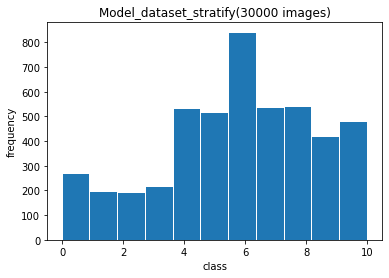

In [125]:
plt.hist(np.array(vali_labels), rwidth=0.97, bins=11)
plt.ylabel('frequency')
plt.xlabel('class')
plt.title('Model_dataset_stratify(30000 images)')
#plt.savefig('pathmnist_vali_labels_hist.png')

In [53]:
# mnist
#images = ep.astensor(torch.from_numpy(np.array(X_images)).to(device))
#images.shape
# pathmnist
#images = ep.astensor(md_images.to(device))
images = ep.astensor(torch.from_numpy(np.array(X_images)).to(device)) # 30000 model dataset images
labels = ep.astensor(torch.from_numpy(np.array(y_labels)).to(device))
images.shape
# chestmnist
#images = ep.astensor(torch.from_numpy(X_images).to(device))

# organmnist
#images = ep.astensor(md_images.to(device))

torch.Size([30547, 1, 28, 28])

### Metrics

In [54]:
def model_metrics(adv_imgs, real_imgs, epi_len):
    """
    Function to compute density & coverage for the between the 
    real & adversarial samples
    
    Parameters
    ---------------
    adv_imgs: ep.tensor, the generated adversarial samples, size: no_of_images x image_dims
    real_imgs: torch.tensor, size: no_of_images x dims
    epi_len: integer, the length or number of epsilons used for the attack
    """
    density = []
    coverage = []
    if not epi_len==1:
        for i in range(epi_len):
            # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
            gen = adv_imgs[i].raw.view(adv_imgs[i].shape[0], -1).cpu()

            # density
            density.append(gem_build_density(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))

            # coverage
            coverage.append(gem_build_coverage(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))
    else:
        gen = adv_imgs.raw.view(adv_imgs.shape[0], -1).cpu()

        # density
        density.append(gem_build_density(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))

        # coverage
        coverage.append(gem_build_coverage(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))
        
    return density, coverage

### - density & coverage for

#### --> model_dataset & adversarial samples 

In [55]:
# resize the real images
real = images.raw.view(images.shape[0], -1)

# 20 values of epsilons were considered
# find the density & coverage for each vgalue of epsilons
#density = []
#coverage = []
#for i in range(len(epsilon)):
    
    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    #gen = adv_images[i].raw.view(adv_images[i].shape[0], -1)
    
    # density
    #density.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    #coverage.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

In [103]:
real.shape
labells = []
for i in range(len(vali_labels)):
    labells.append(vali_labels[i].numpy())
labells = np.array(labells)
labells.reshape(-1).shape

(47096,)

#### --> model_dataset & validation set

In [57]:
# images from the validation set
gen_validate = torch.from_numpy(np.array(vali_images).reshape(len(vali_images), -1)).to(device)
gen_labels = torch.from_numpy(np.array(vali_labels).reshape(-1)).to(device)
print(gen_validate.shape)
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')
print(density_validate, coverage_validate)

torch.Size([5359, 784])
tensor(1.0050, device='cuda:0') tensor(0.5686, device='cuda:0')


chestmnist

In [104]:
# images from the validation set
gen_validate = torch.from_numpy(np.array(vali_images).reshape(len(vali_images), -1)).to(device)
gen_labels = torch.from_numpy((labells)).to(device)
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')
print(density_validate, coverage_validate)

tensor(0.9848, device='cuda:0') tensor(0.3652, device='cuda:0')


#### Attack the model using validation dataset

In [58]:
vali_imagesx = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_labelsx = ep.astensor(torch.from_numpy(np.array(vali_labels).reshape(-1)).to(device))
print(vali_imagesx.shape, vali_labelsx.shape)

torch.Size([5359, 1, 28, 28]) torch.Size([5359])


In [112]:
# chestmnist
vali_imagesx = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_labelsx = ep.astensor(torch.from_numpy(labells).to(device))
print(vali_imagesx.shape, vali_labelsx.shape)
print(type(vali_imagesx), type(vali_labelsx))

torch.Size([3364, 1, 28, 28]) torch.Size([3364, 14])
<class 'eagerpy.tensor.pytorch.PyTorchTensor'> <class 'eagerpy.tensor.pytorch.PyTorchTensor'>


In [59]:
adv_vali, adv_info_vali = model_attack(attack2, original_model, vali_imagesx, vali_labelsx, epsilon)

In [60]:
real.shape

torch.Size([30547, 784])

#### --> model_dataset and validation adversarial samples

In [61]:
vali_den = []
vali_cov = []
for i in range(len(epsilon)):
    
    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    gen = adv_vali[i].raw.view(adv_vali[i].shape[0], -1)
    
    # density
    vali_den.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    vali_cov.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

In [62]:
robust_accuracy = []
for i in range(20):
    acc = 1 - adv_info_vali[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    robust_accuracy.append(acc)

In [63]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate:.5f}")
#print(f"Model_dataset & adversarial samples")
density_data = []
for i in range(len(epsilon)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Vali_adv_density: {:.5f}".format(epsilon[i], robust_accuracy[i], vali_den[i]))
    density_data.append([epsilon[i], robust_accuracy[i], vali_den[i].cpu().numpy()])

density_data = np.array(density_data)

Density
Model_dataset & validation set: density: 1.00496
Epsilon: 0.00000, Accuracy: 0.16%, Vali_adv_density: 1.00496
Epsilon: 0.05263, Accuracy: 0.14%, Vali_adv_density: 1.14924
Epsilon: 0.10526, Accuracy: 0.13%, Vali_adv_density: 1.24325
Epsilon: 0.15789, Accuracy: 0.12%, Vali_adv_density: 1.31775
Epsilon: 0.21053, Accuracy: 0.11%, Vali_adv_density: 1.45546
Epsilon: 0.26316, Accuracy: 0.10%, Vali_adv_density: 1.55824
Epsilon: 0.31579, Accuracy: 0.10%, Vali_adv_density: 1.72178
Epsilon: 0.36842, Accuracy: 0.11%, Vali_adv_density: 1.84788
Epsilon: 0.42105, Accuracy: 0.11%, Vali_adv_density: 2.49770
Epsilon: 0.47368, Accuracy: 0.12%, Vali_adv_density: 3.14103
Epsilon: 0.52632, Accuracy: 0.12%, Vali_adv_density: 3.73794
Epsilon: 0.57895, Accuracy: 0.13%, Vali_adv_density: 4.52439
Epsilon: 0.63158, Accuracy: 0.13%, Vali_adv_density: 5.48162
Epsilon: 0.68421, Accuracy: 0.13%, Vali_adv_density: 6.66643
Epsilon: 0.73684, Accuracy: 0.14%, Vali_adv_density: 7.79328
Epsilon: 0.78947, Accuracy: 

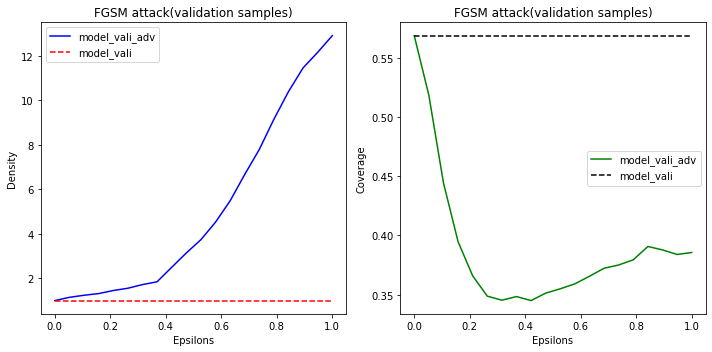

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(epsilon, vali_den, c='b', label='model_vali_adv')
ax[0].plot(epsilon, np.repeat(density_validate.cpu().numpy(), len(epsilon)), ls='--', c='r', label='model_vali')
ax[0].set_xlabel("Epsilons")
ax[0].set_ylabel("Density")
ax[0].set_title("FGSM attack(validation samples)")
ax[0].legend()
ax[1].plot(epsilon, vali_cov, c='g', label='model_vali_adv')
ax[1].plot(epsilon, np.repeat(coverage_validate.cpu().numpy(), len(epsilon)), ls='--', c='k', label='model_vali')
ax[1].set_xlabel("Epsilons")
ax[1].set_ylabel("Coverage")
ax[1].set_title("FGSM attack(validation samples)")
ax[1].legend()
fig.tight_layout()
#plt.savefig("FGSM_attack_vali_samples_30model_pathmnist.png")

In [66]:
print("Coverage")
print(f"Model_dataset & validation set: coverage: {coverage_validate}")
print(f"Model_dataset & adversarial samples")
coverage_data = []
for i in range(len(epsilon)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Vali_adv_coverage: {:.5f}".format(epsilon[i], robust_accuracy[i], vali_cov[i]))
    coverage_data.append([epsilon[i], robust_accuracy[i], vali_cov[i].cpu().numpy()])

coverage_data = np.array(coverage_data)

Coverage
Model_dataset & validation set: coverage: 0.5686319470405579
Model_dataset & adversarial samples
Epsilon: 0.00000, Accuracy: 0.16%, Vali_adv_coverage: 0.56863
Epsilon: 0.05263, Accuracy: 0.14%, Vali_adv_coverage: 0.51838
Epsilon: 0.10526, Accuracy: 0.13%, Vali_adv_coverage: 0.44446
Epsilon: 0.15789, Accuracy: 0.12%, Vali_adv_coverage: 0.39480
Epsilon: 0.21053, Accuracy: 0.11%, Vali_adv_coverage: 0.36596
Epsilon: 0.26316, Accuracy: 0.10%, Vali_adv_coverage: 0.34881
Epsilon: 0.31579, Accuracy: 0.10%, Vali_adv_coverage: 0.34537
Epsilon: 0.36842, Accuracy: 0.11%, Vali_adv_coverage: 0.34845
Epsilon: 0.42105, Accuracy: 0.11%, Vali_adv_coverage: 0.34507
Epsilon: 0.47368, Accuracy: 0.12%, Vali_adv_coverage: 0.35133
Epsilon: 0.52632, Accuracy: 0.12%, Vali_adv_coverage: 0.35499
Epsilon: 0.57895, Accuracy: 0.13%, Vali_adv_coverage: 0.35918
Epsilon: 0.63158, Accuracy: 0.13%, Vali_adv_coverage: 0.36560
Epsilon: 0.68421, Accuracy: 0.13%, Vali_adv_coverage: 0.37234
Epsilon: 0.73684, Accuracy

- save/write the density_data & coverage_data
- info: attack model with model_dataset -> model_dataset & adversarial samples
- attack model validataion_dataset -> model_dataset & vali_adv samples
- model_dataset & vali_dataset

In [141]:
real.shape

torch.Size([54142, 784])

In [67]:
with open('FGSM_attack_pathmnist_1C_NewNet_density.dat', 'w') as newfile:
    newfile.write("# FGSM attack NewNet model with model_dataset(30547 images)" + "\n" +
                 "# and validation_images(5359) 20 epsilon" + "\n" +
                 "# Epsilon Model_accuracy Vali_adv_density" + "\n" +
                 "# Model_dataset & validation set: " + str(density_validate.cpu().numpy()) + "\n" )

with open('FGSM_attack_pathmnist_1C_NewNet_coverage.dat', 'w') as newfile:
    newfile.write("# FGSM attack NewNet model with model_dataset(30547 images)" + "\n" +
                 "# and validation_images(5359) 20 epsilon" + "\n" +
                 "# Epsilon Model_accuracy  Vali_adv_coverage" + "\n" +
                 "# Model_dataset & validation set: " + str(coverage_validate.cpu().numpy()) + "\n")
with open('FGSM_attack_pathmnist_1C_NewNet_density.dat', 'a') as addfile:
    np.savetxt(addfile, density_data)
    
with open('FGSM_attack_pathmnist_1C_NewNet_coverage.dat', 'a') as addfile:
    np.savetxt(addfile, coverage_data)

### FGSM attack mixing of adv validation samples into the validation set and then compute metrics 

In [59]:
xx = np.random.choice(np.arange(2100), size=int(0.50*2100), replace=False)
yy = np.random.choice(np.arange(2100), size=int(0.50*2100), replace=False)

In [58]:
new = vali_imagesx.raw[yy]
nextt= adv_vali[0].raw[~yy]
assert(np.array_equal(vali_imagesx.raw.numpy()[yy], vali_imagesx.raw.numpy()[~yy]))

In [21]:
vali_imagesx = np.array(vali_images)
vali_labelsx = np.array(vali_labels).reshape(-1)
print(vali_imagesx.shape, vali_labelsx.shape)

(2100, 1, 28, 28) (2100,)


In [30]:
new = vali_imagesx.raw[yy]
type(new), new.shape

(torch.Tensor, torch.Size([1575, 1, 28, 28]))

In [27]:
nextt= adv_vali[0].raw[xx]
nextt.shape

torch.Size([525, 1, 28, 28])

In [34]:
torch.cat([new, nextt]).shape, real.shape

(torch.Size([2100, 1, 28, 28]), torch.Size([20000, 784]))

In [60]:
vali25_den=[]; vali25_cov=[]

for i in range(len(epsilon)):
    
    # for normal mixing
    #per_val = int(0.75*2100)
    #adv_vali25_imgs = adv_vali[i].raw[:per_val,...]
    #total_vali_set = torch.cat([vali_imagesx.raw[per_val:,...], adv_vali25_imgs])
    
    # for random mixing
    adv_vali25_imgs = adv_vali[i].raw[yy]
    total_vali_set = torch.cat([vali_imagesx.raw[xx], adv_vali25_imgs])
    
    gen = total_vali_set.view(total_vali_set.shape[0], -1)
    
    # density
    vali25_den.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    vali25_cov.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))
    

In [61]:
metrics25 = []
for i in range(len(epsilon)):
    metrics25.append([epsilon[i], robust_accuracy[i], vali25_den[i].cpu().numpy(), vali25_cov[i].cpu().numpy()])

In [62]:
metrics25 = np.array(metrics25)
metrics25

array([[0.        , 0.98952381, 0.99657148, 0.31305   ],
       [0.05263158, 0.98904762, 1.09542859, 0.34450001],
       [0.10526316, 0.98761905, 1.14742863, 0.36094999],
       [0.15789474, 0.98714286, 1.14895236, 0.36115   ],
       [0.21052632, 0.98571429, 1.10790479, 0.35104999],
       [0.26315789, 0.98333333, 1.02533329, 0.33149999],
       [0.31578947, 0.98238095, 0.90333331, 0.3048    ],
       [0.36842105, 0.97857143, 0.78476197, 0.28      ],
       [0.42105263, 0.97571428, 0.67714286, 0.25885001],
       [0.47368421, 0.96285714, 0.66142857, 0.25545001],
       [0.52631579, 0.93285714, 0.64495242, 0.25150001],
       [0.57894737, 0.88428571, 0.62571436, 0.24695   ],
       [0.63157895, 0.78285715, 0.60895234, 0.24315   ],
       [0.68421053, 0.68095237, 0.59028578, 0.23915   ],
       [0.73684211, 0.56999999, 0.57590479, 0.2362    ],
       [0.78947368, 0.47000003, 0.56304765, 0.2332    ],
       [0.84210526, 0.40047622, 0.54980952, 0.23100001],
       [0.89473684, 0.33190477,

In [63]:
with open('FGSM_attack_mnist_NewNet_50randmix_valiadv.dat', 'w') as newfile:
    newfile.write("# FGSM attack NewNet model with model_dataset(20000 images)" + "\n" +
                 "# and validation_images(2100) 20 epsilon" + "\n" +
                 "# 50% mix of adv vali samples random" + "\n" +
                 "# Epsilon Model_accuracy Vali25_adv_den Vali25_adv_cov" + "\n" )
                 
with open('FGSM_attack_mnist_NewNet_50randmix_valiadv.dat', 'a') as addfile:
    np.savetxt(addfile, metrics25)

### Metrics for FGSM Attack - stats

- ```Batch_modelvali_metrics``` - density & coverage between model_dataset(20000) & validation_dataset(2100) in batches of 100 samples
- ```Batch_modelvali_adv_metrics``` - attack the model in batches using validation_dataset. Computed density & coverage between model_dataset & validation_adv samples

In [68]:
def model_validation_metrics_batches(real, images, labels):
    """
    Function to obtain density and coverage between model_dataset & 
    validation_dataset in batches (100 images)
    
    Parameters
    ---------------
    real: the model_dataset of (20000 images) using stratify split, torch.Tensor
    images: the validation_dataset fo (2100 images) , torch.Tensor
    labels: the labels for the validation_dataset, torch.Tensor
    
    Return
    -----------------
    bacth_model_vali_metrics: list containing density & coverage
    """
    batches = np.arange(0, 5359, 100)
    

    bacth_model_vali_metrics = []
    images = images.view(images.shape[0], -1)
    for i in range(len(batches)-1):

        # model_dataset & validation_dataset in batches
        start = batches[i]; end= batches[i+1]
        gen_validatex = images[start:end,...]
        gen_labelsx = labels[start:end]
        density_validatex = gem_build_density(real, real.shape[0], gen_validatex, 'indexflatl2')
        coverage_validatex = gem_build_coverage(real, real.shape[0], gen_validatex, 'indexflatl2')
        bacth_model_vali_metrics.append([density_validatex.cpu().numpy(), coverage_validatex.cpu().numpy()])
   
    return bacth_model_vali_metrics
        

In [69]:
def batch_validation_attack(real, images, labels, epi):
    """
    Function to obtain the density & coverage between model_dataset & validation_adv dataset
    
    - attack the model in batches of validation dataset(100 images)
    - for each epsilon value, compute the density & coverage for model_dataset & adv batch
    
    Parameters
    -------------
    real: real: the model_dataset of (20000 images) using stratify split, torch.Tensor
    images: images: the validation_dataset fo (2100 images) , torch.Tensor
    labels: the labels for the validation_dataset, torch.Tensor
    epi: np.array, epsilons for the attack
    
    Return
    -------------
    batch_model_vali_adv_metrics: list containing density & coverage
    """
    advs = []
    batch_model_vali_adv_metrics = []
    batches = np.arange(0, 5359, 100)
    images = ep.astensor(images)
    labels = ep.astensor(labels)
    for i in range(len(batches)-1):
        start = batches[i]; end= batches[i+1]
        imagesx = images[start:end,...]
        labelsx = labels[start:end]
        adv_fgsm_batch, adv_fgsm_batch_info = model_attack(attack2, original_model, imagesx, labelsx, epi)
        if(i%5==0):print(f"batch{i}!!!")
        #advs.append(adv_fgsm_batch)
    #print(adv_fgsm_batch[0].shape)
    #print(len(advs[0]))
        for i in range(len(adv_fgsm_batch)):
            gen = adv_fgsm_batch[i].raw.view(len(adv_fgsm_batch[i]), -1)
            densityx = gem_build_density(real, real.shape[0], gen, 'indexflatl2')
            coveragex = gem_build_coverage(real, real.shape[0], gen, 'indexflatl2')
            batch_model_vali_adv_metrics.append([densityx.cpu().numpy(), coveragex.cpu().numpy()])
    
    return batch_model_vali_adv_metrics

In [70]:
# mnist
#realx = torch.from_numpy(np.array(X_images)).view(len(X_images), -1).to(device)

# pathmnist
#realx = md_images.reshape(md_images.shape[0], -1).to(device)
vali_attk_images = torch.from_numpy(np.array(vali_images)).to(device)
vali_attk_labels = torch.from_numpy(np.array(vali_labels).reshape(-1)).to(device)
epsilon = np.linspace(0.0, 1, num=20)


In [71]:
real.shape, vali_attk_images.shape, vali_attk_labels.shape

(torch.Size([30547, 784]), torch.Size([5359, 1, 28, 28]), torch.Size([5359]))

In [72]:
Batch_modelvali_metrics = model_validation_metrics_batches(real, vali_attk_images, vali_attk_labels)

In [78]:
len(Batch_modelvali_metrics)

53

In [79]:
with open('FGSM_attack_pathmnist_1C_100batch_metrics.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(30547 images)" + "\n" +
                 "# and validation_images(5359) 20 epsilon in batches of 100 images" + "\n" +
                 "# metrics between model_dataset & validation dataset" + "\n" +
                 "# Model_vali_density Model_vali_coverage" + "\n" )
with open('FGSM_attack_pathmnist_1C_100batch_metrics.dat', 'a') as newfile:
    np.savetxt(newfile, np.array(Batch_modelvali_metrics))

In [76]:
Batch_modelvali_adv_metrics = batch_validation_attack(real, vali_attk_images, vali_attk_labels, epsilon)

batch0!!!
batch5!!!
batch10!!!
batch15!!!
batch20!!!
batch25!!!
batch30!!!
batch35!!!
batch40!!!
batch45!!!
batch50!!!


In [77]:
with open('FGSM_attack_pathmnist_1C_100batch_adv_metrics.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(30547 images)" + "\n" +
                 "# and validation_images(5359) 20 epsilon in batches of 100 images" + "\n" +
                 "# metrics between model_dataset & adv validation dataset" + "\n" +
                 "# Model_vali_adv_density Model_vali_adv_coverage" + "\n" )
with open('FGSM_attack_pathmnist_1C_100batch_adv_metrics.dat', 'a') as newfile:
    np.savetxt(newfile, np.array(Batch_modelvali_adv_metrics))

## Attack the model using ```Boundary attack```

This attack works fine i.e, adversarial samples are created if epsilon is assigned as None

In [88]:
# manage memory
#del md_images; del md_labels; del images; del labels
#torch.cuda.empty_cache()
#print(torch.cuda.memory_allocated())

In [12]:
BdyAttack = fb.attacks.BoundaryAttack()

#### Test attack using images & labels from foolbox

This step is done to make sure adversarial samples are generated with the current version of foolbox

In [66]:
test_imgs, test_labels = ep.astensors(*samples(original_model, dataset='mnist', batchsize=16))
raw_advs, clipped_advs, success = BdyAttack(original_model, test_imgs, test_labels, epsilons=None)

In [67]:
robust_accuracy = 1 - success.float32().mean(axis=-1)
print("robust accuracy: ", robust_accuracy)

robust accuracy:  PyTorchTensor(tensor(0., device='cuda:0'))


#### Test attack using validation images

A subset of 10 images from the validation_set is used for the attack

In [10]:
vali_attk_images = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_attk_labels = ep.astensor(torch.from_numpy(np.array(vali_labels)).to(device))

In [11]:
vali_attk_labels = vali_attk_labels.reshape(-1)

In [11]:
vali_attk_labels.shape

torch.Size([2100])

In [69]:
attak = fb.attacks.BoundaryAttack()
_, _, newsuccess = BdyAttack(original_model, vali_attk_images[:10,...], vali_attk_labels[:10], epsilons=None)

In [70]:
robust_acc = 1 - newsuccess.float32().mean(axis=-1)
print("robust accuracy: ", robust_accuracy)

robust accuracy:  PyTorchTensor(tensor(0., device='cuda:0'))


### Attack the model using entire validation_dataset

- the Boundary Attack cannot be implemented if the starting images are not adversaries
- to create these adversarial samples, ```init_attack``` needs to be specified
- any of the attacks inherited from ```Minimization Attack``` can be used for this purpose
- all the initial samples should be strictly adversarial samples

##### Two different attacks were experimented
- ```SaltandPepper```, ```LinearSearchBlendedUniformNoiseAttack```
- modify the hyperparameters within these attacks to generate the adversarial samples
- the generated samples are given as the starting points for the ```BoundaryAttack```
- time complexity increases with changing these hyperparameters

In [20]:
vali_images = np.array(vali_images)
vali_labels = np.array(val_labels)

In [21]:
new = []
for i in range(len(vali_labels)):
    new.append(vali_labels[0].numpy())

In [22]:
vali_labels = np.array(new)

In [23]:
vali_images.shape

(3364, 1, 28, 28)

In [180]:
# pathmnist
_, X_images, _, y_labels = train_test_split(vali_images, vali_labels, test_size=0.3, random_state=42, stratify=vali_labels)

In [16]:
vali_attk_images.shape, type(vali_attk_labels)

(torch.Size([4708, 1, 28, 28]), eagerpy.tensor.pytorch.PyTorchTensor)

In [20]:
s_attack = fb.attacks.SaltAndPepperNoiseAttack(steps=5000, across_channels=True)
n_attack = fb.attacks.LinearSearchBlendedUniformNoiseAttack(steps=1000, directions=2000)
l_attack = fb.attacks.LinfDeepFoolAttack()
lb_attack = fb.attacks.L0BrendelBethgeAttack()
criterion = fb.criteria.Misclassification(vali_attk_labels)
_, adv_lsbu, adv_bdy_info = n_attack(original_model, vali_attk_images, vali_attk_labels, epsilons=None)

In [21]:
adv_bdy_info.float32()

PyTorchTensor(tensor([1., 1., 1.,  ..., 1., 1., 1.]))

In [77]:
s = adv_bdy_info.float32().raw
d = torch.where(s==1)
adv_lsbu_new = adv_lsbu[d]
adv_lsbu_new.shape
#np.unique(vali_attk_labels[d].raw.numpy(), return_counts=unts=True)

torch.Size([5359, 3, 28, 28])

In [22]:
print(f"acc: {1 - adv_bdy_info.float32().mean(axis=-1)}")

acc: 0.0


In [23]:
_, adv_bdy, adv_bdy_info = BdyAttack(original_model, vali_attk_images, vali_attk_labels, starting_points=adv_lsbu, epsilons=None)

## adv_bdy_info

In [24]:
print(f"acc: {1 - adv_bdy_info.float32().mean(axis=-1)}")

acc: 0.0


### Metrics

#### - entire model_dataset (67000) & validation_dataset (2100)

In [13]:
vali_attk_images.shape, vali_attk_labels.shape, md_images.shape#, real.shape

(torch.Size([4708, 1, 28, 28]),
 torch.Size([4708]),
 torch.Size([54142, 1, 28, 28]))

In [18]:
real = md_images.reshape(md_images.shape[0], -1)

In [27]:
#real = md_images.view(md_images.shape[0], -1).to(device)
# images from the validation set
# for pathmnist 30000 model_dataset images are used 
gen_validate = vali_attk_images.raw.view(vali_attk_images.shape[0], -1)
gen_labels = vali_attk_labels
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')
print(density_validate, coverage_validate)

tensor(1.0071) tensor(0.1424)


#### - model_dataset & validation_dataset adversarials

In [28]:
gen_adv_val = adv_bdy.raw.view(adv_bdy.shape[0], -1)
model_density_val = gem_build_density(real, real.shape[0], gen_adv_val, 'indexflatl2')
model_coverage_val = gem_build_coverage(real, real.shape[0], gen_adv_val, 'indexflatl2')
print(gen_adv_val.shape, real.shape)
print(model_density_val, model_coverage_val)

torch.Size([2100, 784]) torch.Size([67900, 784])
tensor(0.1581) tensor(0.0047)


In [29]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate:.5f}")
print(f"Model_dataset & validation adv (2100): density: {model_density_val:.5f}")

Density
Model_dataset & validation set: density: 1.00714
Model_dataset & validation adv (2100): density: 0.15810


### Attack the model with validation_dataset in batches

- create the adversarial samples for each batch exclusively
- use these images as starting_points for boundary attack

#### Get the adversarial starting points for each Batch
- load the 100Batch_Vali_Adv_LSBU.pt file for the saved LSBU adversarials( batch size of 100 images)
- load the 42Batch_Vali_Adv_LSBU.pt file for the saved LSBU adversarials( batch size of 42 images)

In [225]:
batches = np.arange(0, 4707, 100)
success = []
batch_adv_samples = []
for i in range(len(batches)-1):
    start = batches[i]; end= batches[i+1]
    _, batch_adv_lsbu, adv_bdy_info = n_attack(original_model, vali_attk_images[start:end,...], vali_attk_labels[start:end], epsilons=None)
    print(f"acc: {1 - adv_bdy_info.float32().mean(axis=-1)}")
    success.append(adv_bdy_info); batch_adv_samples.append(batch_adv_lsbu.raw)

/home/venkat31/.conda/envs/n2gem/lib/python3.8/site-packages/foolbox/attacks/blended_noise.py:82: UserWarning: LinearSearchBlendedUniformNoiseAttack failed to draw sufficient random inputs that are adversarial (92 / 100).
  warnings.warn(


acc: 0.06999999284744263


/home/venkat31/.conda/envs/n2gem/lib/python3.8/site-packages/foolbox/attacks/blended_noise.py:82: UserWarning: LinearSearchBlendedUniformNoiseAttack failed to draw sufficient random inputs that are adversarial (93 / 100).
  warnings.warn(


acc: 0.06999999284744263


/home/venkat31/.conda/envs/n2gem/lib/python3.8/site-packages/foolbox/attacks/blended_noise.py:82: UserWarning: LinearSearchBlendedUniformNoiseAttack failed to draw sufficient random inputs that are adversarial (86 / 100).
  warnings.warn(


acc: 0.14000004529953003


/home/venkat31/.conda/envs/n2gem/lib/python3.8/site-packages/foolbox/attacks/blended_noise.py:82: UserWarning: LinearSearchBlendedUniformNoiseAttack failed to draw sufficient random inputs that are adversarial (87 / 100).
  warnings.warn(


KeyboardInterrupt: 

In [85]:
len(np.arange(0, 5359, 100))

54

In [90]:
batch_adv_lsbu_samples = torch.stack(batch_adv_samples)
torch.save(batch_adv_lsbu_samples, '140Batch_Vali_Adv_LSBU.pt')

In [91]:
#batch_lsbu_adv = torch.load('100Batch_Vali_Adv_LSBU.pt', map_location='cpu').to(device)
batch_lsbu_adv = torch.load('140Batch_Vali_Adv_LSBU.pt', map_location='cpu').to(device)

### BoundaryAttack on the model using batches of validation_dataset

In [44]:
batches = np.arange(0, 4708, 49)
len(batches)

97

In [45]:
# 53, 100, 150, 200, 250, 300 
batches = np.arange(0, 4707, 49)
batch_bdy_adv = []
batch_bdy_info = []
for i in range(len(batches)-1):
    start = batches[i]; end= batches[i+1]
    _, adv_bdy, adv_bdy_info = BdyAttack(original_model, vali_attk_images[start:end,...], vali_attk_labels[start:end], 
                                          epsilons=None) #starting_points=batch_lsbu_adv[i],
    batch_bdy_adv.append(adv_bdy); batch_bdy_info.append(adv_bdy_info)
    if(i%10==0):print(f"batch{i}")

batch0
batch10
batch20
batch30
batch40
batch50
batch60
batch70
batch80
batch90


### Metrics

- #### model_dataset & validation_dataset in batches
- #### model_deataset & validation adv in batches

In [24]:
real = real.to(device)

In [46]:
batch_density_validate = []
batch_coverage_validate = []
batch_model_density = []
batch_model_coverage = []

for i in range(len(batches)-1):
    # model_dataset & validation_dataset in batches
    start = batches[i]; end= batches[i+1]
    bth_val_imgs = vali_attk_images[start:end,...]
    gen_validatex = bth_val_imgs.raw.view(bth_val_imgs.shape[0], -1)
    gen_labelsx = vali_attk_labels[start:end].raw
    density_validatex = gem_build_density(real, real.shape[0], gen_validatex, 'indexflatl2')
    coverage_validatex = gem_build_coverage(real, real.shape[0], gen_validatex, 'indexflatl2')
    
    # model_dataset & validation_dataset adversarials in batches
    gen_adv_valx = batch_bdy_adv[i].raw.view(batch_bdy_adv[i].shape[0], -1)
    model_density_valx = gem_build_density(real, real.shape[0], gen_adv_valx, 'indexflatl2')
    model_coverage_valx = gem_build_coverage(real, real.shape[0], gen_adv_valx, 'indexflatl2')
    
    batch_density_validate.append(density_validatex)
    batch_coverage_validate.append(coverage_validatex)
    batch_model_density.append(model_density_valx)
    batch_model_coverage.append(model_coverage_valx)


In [27]:
real.shape, vali_attk_images.shape

(torch.Size([54142, 784]), torch.Size([4708, 1, 28, 28]))

In [32]:
with open('Boundary_attack_organmnist_100batch_metrics.dat', 'w') as newfile:
    newfile.write("# Boundary attack with validation_dataset(4708 images)" + "\n" +
                 "# and metrics using model_dataset(54142)" + "\n" +
                 "# Model_dataset & validation set: density: " + str(density_validate.cpu().numpy()) + "\n" +
                 "# Model_dataset & validation adv (4708): density: " + str(model_density_val.cpu().numpy()) + "\n" +
                 "# Model_dataset & validation set: coverage: " + str(coverage_validate.cpu().numpy()) + "\n" +
                 "# Model_dataset & validation adv (4708): coverage: " + str(model_coverage_val.cpu().numpy()) + "\n" + 
                 "# batch_no model_val_density model_val_adv_density model_val_coverage model_val_adv_coverage" + "\n")
    
with open('Boundary_attack_organmnist_100batch_metrics.dat', 'a') as nefile:
    for i in range (len(batch_density_validate)):
        nefile.write(str(i)+ " " + str(batch_density_validate[i].cpu().numpy())+ " " + str(batch_model_density[i].cpu().numpy())+ " " +
                    str(batch_coverage_validate[i].cpu().numpy()) + " " + str(batch_model_coverage[i].cpu().numpy()) + "\n")

In [47]:
with open('Boundary_attack_organmnist_49batch_metrics.dat', 'w') as newfile:
    newfile.write("# Boundary attack with validation_dataset(4708 images)" + "\n" +
                 "# and metrics using model_dataset(54142)" + "\n" +
                 "# Model_dataset & validation set: density: " + str(1.0169499) + "\n" +
                 "# Model_dataset & validation adv (4708): density: " + str(2.7256584) + "\n" +
                 "# Model_dataset & validation set: coverage: " + str(0.34394738) + "\n" +
                 "# Model_dataset & validation adv (4708): coverage: " + str(0.2428983) + "\n" + 
                 "# batch_no model_val_density model_val_adv_density model_val_coverage model_val_adv_coverage" + "\n")
    
with open('Boundary_attack_organmnist_49batch_metrics.dat', 'a') as nefile:
    for i in range (len(batch_density_validate)):
        nefile.write(str(i)+ " " + str(batch_density_validate[i].cpu().numpy())+ " " + str(batch_model_density[i].cpu().numpy())+ " " +
                    str(batch_coverage_validate[i].cpu().numpy()) + " " + str(batch_model_coverage[i].cpu().numpy()) + "\n")

## The End

In [1]:
import medmnist